BLASTN search run with Max Target Sequences=1000, expect threshold=0.0001. Match/mismatch scores were set to 2,-3

Seqdump.txt contains BLASTN output of top 1000 matches. The top match is a 100% match and is therefore identical to the query. 

Here, transeq is used to create the file protein.txt, which is identical to seqdump.txt but is translated to aminio acid sequence.

Mafft is used to allign amino aicd sequences which are stored in protein_alligned.txt. 

In [1]:
%%bash
transeq -sequence seqdump.txt -outseq protein.txt
mafft --auto protein.txt > protein_alligned.txt

Translate nucleic acid sequences
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 977 ambiguous characters.
  901 / 1000
done.

Constructing a UPGMA tree (efffree=0) ... 
  990 / 1000
done.

Progressive alignment 1/2... 
STEP   403 / 999  f
Reallocating..done. *alloclen = 8406
STEP   901 / 999  f
Reallocating..done. *alloclen = 10122

done.

Making a distance matrix from msa.. 
  900 / 1000
done.

Constructing a UPGMA tree (efffree=1) ... 
  990 / 1000
done.

Progressive alignment 2/2... 
STEP   701 / 999  f
Reallocating..done. *alloclen = 8420
STEP   901 / 999  f
Reallocating..done. *alloclen = 9946

done.

disttbfast (aa) Version 7.471
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output

In [2]:
import sys
from fasta_iterator_class import FASTAReader 

In [90]:
codontable = {
'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'
}

The commented out loop prints out the list of sequence names from both AA and NT files. Manual examination reveals that the sequences are organized in the same order

In [232]:
# use FASTAReader to open NT and AA sequences
protein_alligned_file = FASTAReader(open('protein_alligned.txt'))
seq_dump_file = FASTAReader(open('seqdump.txt'))

aa_to_nt_list = []

# Loop through aa and nt sequences at the same time 
for protein_alligned, nt_sequence in zip(protein_alligned_file, seq_dump_file):
    aa_to_nt = ""
    nt_pos_counter = 0
    #look through amino acid sequence and add either blanks or nucleotides from nt file
    for aa in protein_alligned[1]:
        if aa =='-':
            aa_to_nt+="---"
        else:
            aa_to_nt+=nt_sequence[1][nt_pos_counter]
            nt_pos_counter+=1
            aa_to_nt+=nt_sequence[1][nt_pos_counter]
            nt_pos_counter+=1
            aa_to_nt+=nt_sequence[1][nt_pos_counter]
            nt_pos_counter+=1
        #store as a tuple
    converted_tup = (protein_alligned[0], aa_to_nt)
    aa_to_nt_list.append(converted_tup)

In [233]:
# Checking that everything is the same length:
print(len(aa_to_nt_list[0][1]))
print(len(aa_to_nt_list[583][1]))
print(len(aa_to_nt_list[-1][1]))

17637
17637
17637


it is!

To calculate dN/dS, first I split the sequence into nucleotides. Then, I will compare the reference (1st seq) with all the others. Whenever a mismatch occurs in the codon, I will check to see if the AA sequence is the same to classify as synonymous or nonsynonymous.

In [234]:
# Creating a verstion of the query that is entirely in codons
query_codons = []
codon=""
for bp in aa_to_nt_list[1][1]:
    codon+=bp
    if len(codon)==3:
        query_codons.append(codon)
        codon=""

In [235]:
# making a list to store dn and ds values 
dN_list=[]
for codon in query_codons:
    dN_list.append(0)

dS_list=[]
for codon in query_codons:
    dS_list.append(0)

# Loop through aa and nt sequences at the same time 
for sequence in aa_to_nt_list:
    for cod_position in range(0, len(query_codons)):
        codon=sequence[1][cod_position*3]+sequence[1][cod_position*3+1]+sequence[1][cod_position*3+2]
        if query_codons[cod_position] != "---" and codon != "---":
             if codon != query_codons[cod_position]:
                #print(codon, query_codons[cod_position])
                if codon in codontable.keys() and query_codons[cod_position] in codontable.keys():
                    if codontable[codon] == codontable[query_codons[cod_position]]:
                        dS_list[cod_position]+=1
                        #print('yes', codon, codontable[codon], query_codons[cod_position], codontable[query_codons[cod_position]])
                    else:
                        dN_list[cod_position]+=1
                        #print('no', codon, codontable[codon], query_codons[cod_position], codontable[query_codons[cod_position]])

Making dn_ds_list, which contains codon positions and ratios of dN and dS, and D, which contains difference of dN and dS used for getting z score

In [245]:
import math
import scipy.stats

dn_ds_list = []
D = []
for codon in range(0, len(dN_list)):
    if dN_list[codon] != 0 and dS_list[codon] != 0:
        dn_ds_list.append( (codon, dN_list[codon]/dS_list[codon] ) )
        D.append( dN_list[codon] - dS_list[codon] )
        
abs_z_values = abs(scipy.stats.zscore(D))
sig = []
nonsig = []
for i in range(0,len(p_values)):
    if abs_z_values[i] > 1.96:
        sig.append(dn_ds_list[i])
    else:
        nonsig.append(dn_ds_list[i])

Making lists for plotting

In [246]:
position = []
ratios = []
for cd in dn_ds_list:
    position.append(cd[0])
    ratios.append(cd[1])

In [247]:
sig_position = []
sig_ratios = []
for cd in sig:
    sig_position.append(cd[0])
    sig_ratios.append(cd[1])

non_sig_position = []
non_sig_ratios = []
for cd in nonsig:
    non_sig_position.append(cd[0])
    non_sig_ratios.append(cd[1])

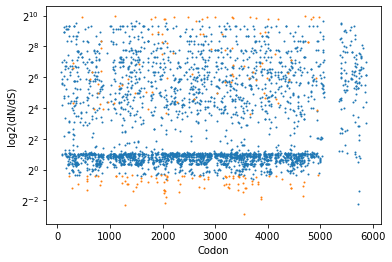

In [248]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)


# plot the data
plt.scatter(non_sig_position,non_sig_ratios, s=1) 
plt.scatter(sig_position,sig_ratios, s=1) 
ax.set_yscale('log', base=2)
ax.set_xlabel('Codon')
ax.set_ylabel('log2(dN/dS)')
plt.show()